This code was gleaned from the following web site/blog:

https://pythonforfinance.net/2019/07/02/investment-portfolio-optimisation-with-python-revisited/
    
Author: Stuart Jameison, Barclays Bank

To set up the first part of the problem at hand – say we are building, or have a portfolio of stocks, and we wish to balance/rebalance our holdings in such as way that they match the weights that would match the “optimal” weights if “optimal” meant the portfolio with the highest Sharpe ratio, also known as the “mean-variance optimal” portfolio.

The first way I am going to attempt this is through a “brute force” style Monte Carlo approach. With this approach we try to discover the optimal weights by simply creating a large number of random portfolios, all with varying combinations of constituent stock weightings, calculating and recording the Sharpe ratio of each of these randomly weighted portfolio and then finally extracting the details corresponding to the result with the highest value.

The random weightings that we create in this example will be bound by the constraint that they must be between zero and one for each of the individual stocks, and also that all the weights must sum to one to represent an investment of 100% of our theoretical capital.

The more random portfolios that we create and calculate the Sharpe ratio for, theoretically the closer we get to the weightings of the “real” optimal portfolio. We will always experience some discrepancies however as we can never run enough simulated portfolios to replicate the exact weights we are searching for…we can get close, but never exact.

In this example we will create a portfolio of 5 stocks and run 100,000 simulated portfolios to produce our results. These results will then be plotted and both the “optimal” portfolio with the highest recorded Sharpe ratio and the “minimum variance portfolio” will be highlighted and marked for identification. The “minimum variance portfolio” is just what it sounds like, the portfolio with the lowest recorded variance (which also, by definition displays the lowest recorded standard deviation or “volatility”)

In [1]:
!python --version


Python 3.7.6


In [9]:
!pip list

Package                            Version             Location                                 
---------------------------------- ------------------- -----------------------------------------
aiodns                             1.1.1               
aiohttp                            3.6.2               
alabaster                          0.7.12              
alembic                            1.4.2               
alpha-vantage                      2.2.0               /Users/jrp/Documents/GitHub/alpha_vantage
anaconda-client                    1.7.2               
anaconda-navigator                 1.9.12              
anaconda-project                   0.8.3               
appdirs                            1.4.4               
applaunchservices                  0.2.1               
appnope                            0.1.0               
appscript                          1.0.1               
argh                               0.26.2              
asn1crypto                         1.

In [6]:
!pip3 install pandas


In [2]:
import pandas as pd  
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
start = datetime.datetime(2020, 10, 1)
end = datetime.datetime(2020, 10, 7)
x = data.DataReader('NFLX', 'yahoo', start, end)
print(type(x))

<class 'pandas.core.frame.DataFrame'>


In [5]:
#tickers = ['AAPL', 'MSFT', 'NFLX', 'AMZN', 'GOOG']
tickers= ['DOCU', 'SHOP', 'WMT']
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 10, 7)
df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers
print(df)

                  DOCU         SHOP         WMT
Date                                           
2020-01-02   75.900002   407.809998  116.987091
2020-01-03   75.559998   404.290009  115.954330
2020-01-06   75.389999   413.329987  115.718269
2020-01-07   75.239998   414.500000  114.646172
2020-01-08   76.269997   418.100006  114.252739
...                ...          ...         ...
2020-10-01  222.259995  1054.430054  142.558899
2020-10-02  218.270004  1028.989990  139.988297
2020-10-05  225.919998  1065.530029  141.283569
2020-10-06  221.199997  1041.250000  140.117828
2020-10-07  224.050003  1073.430054  140.376877

[194 rows x 3 columns]


The results can be seen below with a calculation of the CoVariance for each

In [62]:
#convert daily stock prices into daily returns
returns = df.pct_change()
returns.round(6)
print(returns)

                DOCU      SHOP       WMT
Date                                    
2020-01-02       NaN       NaN       NaN
2020-01-03 -0.004480 -0.008631 -0.008828
2020-01-06 -0.002250  0.022360 -0.002036
2020-01-07 -0.001990  0.002831 -0.009265
2020-01-08  0.013690  0.008685 -0.003432
...              ...       ...       ...
2020-10-01  0.032615  0.030754  0.022657
2020-10-02 -0.017952 -0.024127 -0.018032
2020-10-05  0.035048  0.035511  0.009253
2020-10-06 -0.020892 -0.022787 -0.008251
2020-10-07  0.012884  0.030905  0.001849

[194 rows x 3 columns]


In [63]:
#calculate mean daily return and covariance of daily returns
print(returns)
print(type(returns))
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

print(cov_matrix)
print(mean_daily_returns)

                DOCU      SHOP       WMT
Date                                    
2020-01-02       NaN       NaN       NaN
2020-01-03 -0.004480 -0.008631 -0.008828
2020-01-06 -0.002250  0.022360 -0.002036
2020-01-07 -0.001990  0.002831 -0.009265
2020-01-08  0.013690  0.008685 -0.003432
...              ...       ...       ...
2020-10-01  0.032615  0.030754  0.022657
2020-10-02 -0.017952 -0.024127 -0.018032
2020-10-05  0.035048  0.035511  0.009253
2020-10-06 -0.020892 -0.022787 -0.008251
2020-10-07  0.012884  0.030905  0.001849

[194 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
          DOCU      SHOP       WMT
DOCU  0.001467  0.000986  0.000337
SHOP  0.000986  0.001932  0.000358
WMT   0.000337  0.000358  0.000488
DOCU    0.006340
SHOP    0.005990
WMT     0.001184
dtype: float64


The results will be produced by defining and running two functions (shown below). The first function (calc_portfolio_perf) is created to help us calculate the annualised return, annualised standard deviation and annualised Sharpe ratio of a portfolio, given that we pass it certain arguments of course. The arguments we will provide are, the weights of the portfolio constituents, the mean daily return of each of those constituents (as calculated over the historic data that we downloaded earlier), the co-variance matrix of the constituents and finally the risk free interest rate. The risk free rate is required for the calculation of the Sharpe ratio and should be provided as an annualised rate. In this example I have chosen to set the rate to zero, but the functionality is there to easily amend this for your own purposes.

The second function deals with the overall creation of multiple randomly weighted portfolios, which are then passed to the function we just described above to calculate the required values we wish to record. The values are then indeed recorded and once all portfolios have been simulated, the results are stored in and returned as a Pandas DataFrame.

The values recorded are as previously mentioned, the annualised return, annualised standard deviation and annualised Sharpe ratio – we also store the weights of each stock in the portfolio that generated those values.

In [64]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df

Now we quickly calculate the mean returns and co-variance matrix of our list of stocks, set the number of portfolios we wish to simulate and finally we set the desired value of the risk free rate. We then call the required function and store the results in a variable so we can then extract and visualise them.

In [73]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)
print(results_frame)

            ret     stdev    sharpe      DOCU      SHOP       WMT
0      0.681588  0.374262  1.821149  0.031997  0.282092  0.685911
1      1.107651  0.437553  2.531470  0.523687  0.106344  0.369969
2      0.900926  0.389178  2.314943  0.306608  0.168562  0.524829
3      0.672246  0.357442  1.880716  0.286393  0.001453  0.712155
4      0.748902  0.363659  2.059352  0.239506  0.115041  0.645452
...         ...       ...       ...       ...       ...       ...
99995  1.468050  0.540666  2.715263  0.614832  0.306104  0.079063
99996  1.319210  0.494108  2.669884  0.579875  0.220726  0.199399
99997  0.792138  0.374497  2.115208  0.184777  0.209454  0.605769
99998  1.171822  0.469118  2.497927  0.290048  0.409981  0.299971
99999  1.098891  0.435595  2.522735  0.374466  0.259202  0.366332

[100000 rows x 6 columns]


Below we visualise the results of all the simulated portfolios, plotting each portfolio by it’s corresponding values of annualised return (y-axis) and annualised volatility (x-axis), and also identify the 2 portfolios we are interested in. These are highlighted with a red star for the maximum Sharp ratio portfolio, and a green star for the minimum variance portfolio.

The data points are coloured according to their respective Sharpe ratios, with blue signifying a higher value, and red a lower value.

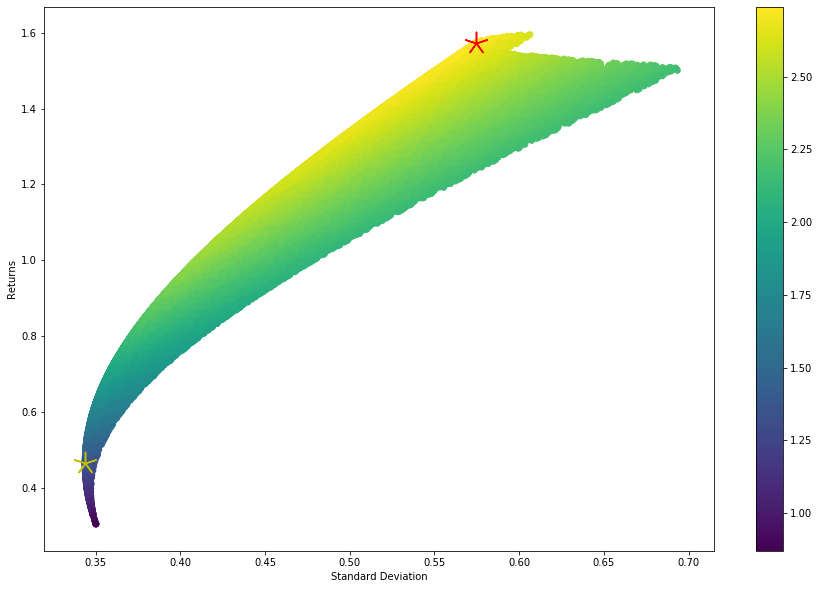

In [74]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='viridis')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,2,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,2,0),color='y',s=500)
plt.show()

Now we just take a look at the stock weightings that made up those two portfolios, along with the annualised return, annualised standard deviation and annualised Sharpe ratio. These are shown below firstly for the maximum Sharpe portfolio, and then for the minimum variance portfolio.

In [75]:
max_sharpe_port.to_frame().T


,ret,stdev,sharpe,DOCU,SHOP,WMT
64391,1.572517,0.574266,2.738306,0.713749,0.28623,0.000021


In [76]:
min_vol_port.to_frame().T


,ret,stdev,sharpe,DOCU,SHOP,WMT
95078,0.465752,0.343797,1.354731,0.100168,0.030761,0.869071


Next we begin the second approach to the optimisation – that uses the Scipy “optimize” functions. The code is fairly brief but there are a couple of things worth mentioning. Firstly, Scipy offers a “minimize” function, but no “maximize” function. Saying as we wish to maximise the Sharpe ration, this may seem like a bit of a problem at first glance, but it is easily solved by realising that the maximisation of the Sharpe ratio is analogous to the minimisation of the negative Sharpe ratio – that is literally just the Sharpe ratio value with a minus sign stuck at the front.

So firstly we define a function (very similar to our earlier function) that calculates and returns the negative Sharpe ratio of a portfolio.

Then we define a variable I have labelled “constraints”. This can look somewhat strange at first if you haven’t used the Scipy “optimize” capabilities before.

Let me run through each entry and hopefully clarify them somewhat:

Firstly, as we will be using the ‘SLSQP’ method in our “minimize” function (which stands for Sequential Least Squares Programming), the constraints argument must be in the format of a list of dictionaries, containing the fields “type” and “fun”, with the optional fields “jac” and “args”. We only need the fields “type”, “fun” and “args” so lets run through them.

The “type” can be either “eq” or “ineq” referring to “equality” or “inequality” respectively. The “fun” refers to the function defining the constraint, in our case the constraint that the sum of the stock weights must be 1. The way this needs to be entered is sort of a bit “back to front”. The “eq” means we are looking for our function to equate to zero (this is what the equality is in reference to – equality to zero in effect). So the most simple way to achieve this is to create a lambda function that returns the sum of the portfolio weights, minus 1. The constraint that this needs to sum to zero (that the function needs to equate to zero) by definition means that the weights must sum to 1. It’s admittedly a bit strange looking for some people at first, but there you go…

The “bounds” just specify that each individual stock weight must be between 0 and 1, with the “args” being the arguments that we want to pass to the function we are trying to minimise (calc_neg_sharpe) – that is all the arguments EXCEPT the weights vector which of course is the variable we are changing to optimise the output.

In [77]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

When we run the optimisation, we get the following results:

In [78]:
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']],index=tickers).T

,DOCU,SHOP,WMT
0,0.71,0.29,0.0


When we compare this output with that from our Monte Carlo approach we can see that they are similar, but of course as explained above they will not be identical. The weightings of each stock are not more than a couple of percent away between the two approaches…hopefully that indicates we did something right at least!

We can then just use the same approach to identify the minimum variance portfolio. It’s almost the same code as above although this time we need to define a function to calculate and return the volatility of a portfolio, and use it as the function we wish the minimise (“calc_portfolio_std”). This time there is no need to negate the output of our function as it is already a minimisation problem this time (as opposed to the Sharpe ratio when we wanted to find the maximum)

The constraints remain the same, so we just adapt the “max_sharpe_ratio” function above, rename it to “min_variance” and change the “args” variable to hold the correct arguments that we need to pass to our new “calc_portfolio_std” that we are minimising.

In [80]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std
def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_variance = min_variance(mean_returns, cov)



When we run the optimisation, we get the following results:

In [81]:
pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers).T


,DOCU,SHOP,WMT
0,0.1,0.03,0.87


Again we see the results are very close to those we were presented with when using the Monte Carlo approach.

Great stuff so far! Now let us move on to the problem of identifying the portfolio weights that minimise the Value at Risk (VaR).

The logic is very similar to that followed when dealing with the first Monte Carlo problem above, so I will try to identify the changes and differences only rather than repeat myself too much. We start again by creating our two functions – but this time instead of one that returns portfolio return, volatility and Sharpe ratio, it returns the parametric portfolio VaR to a confidence level determined by the value of the “alpha” argument (confidence level will be 1 – alpha), and to a time scale determined by the “days” argument.

The method I have chosen to use for the VaR calculation is to scale the portfolio standard deviation by the square root of the “days” value, then subtract the scaled standard deviation, multiplied by the relevant “Z value” according to the chosen value of “alpha” from the portfolio daily mean returns which have been scaled linearly according to the “days” value. This final VaR value has then been converted to an absolute value, as VaR is more often than not reported as a positive value (it also allows us to run the required “minimization” function when it is cast as a positive value).

As a note, VaR is sometimes calculated in such a way that the mean returns of the portfolio are considered to be small enough that they can be entered into the equation with a zero value – this tends to make more sense when we are looking at VaR over short time periods like a daily or a weekly VaR figure, however when we start to look at annualised VaR figures it begins to make more sense to incorporate a “non-zero” return element.

Finally, the above approach where returns are entered as zero (effectively removing them from the calculation) is sometimes favoured as it is a more “pessimistic” view of a portfolio’s VaR and when dealing with the quantification of risk, or in fact any “downside” forecast, it is wise to err on the side of caution and make decisions based on a worst case scenario. The cost of being wrong due to underestimating VaR and that due to overestimating VaR is almost never symmetric – there is almost always a higher cost to an underestimation.

The second function is pretty much analogous to the one used for the Sharpe optimisation with some slight changes to variable names, parameters and arguments passed of course.

In [83]:
def calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var
def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])
        
    return results_df

Similar variables are defined as before this time with the addition of “days” and “alpha”. The “days” variable determines the time frame over which the VaR figure is calculated/scaled and the “alpha” variable is the significance level used for the calculation (with confidence level being (1 – significance level) as mentioned just above).

I have chosen 252 days (to represent a year’s worth of trading days) and an alpha of 0.05, corresponding to a 95% confidence level. So that is to say we will be calculating the one-year 95% VaR, and attempting to minimise that value.

Now let’s run the simulation function and plot the results again.

In [84]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
days = 252
alpha = 0.05
results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)

This time we plot the results of each portfolio with annualised return remaining on the y-axis but the x-axis this time representing the portfolio VaR (rather than standard deviation). The plot colours the data points according to the value of VaR for that portfolio.

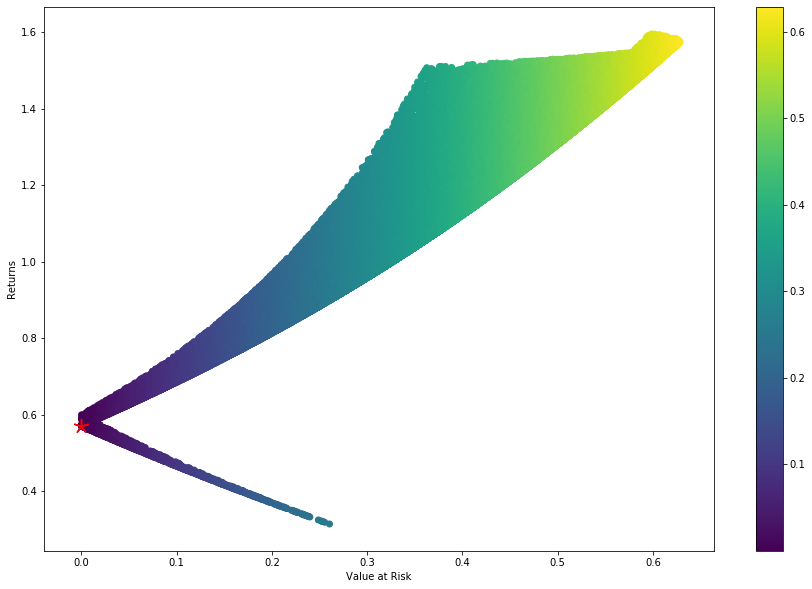

In [85]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,cmap='viridis')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,2,0),color='r',s=200)
plt.show()

The weights of the resulting minimum VaR portfolio is as shown below.

In [86]:
min_VaR_port.to_frame().T

,ret,stdev,VaR,DOCU,SHOP,WMT
40252,0.570594,0.34689,0.00001,0.179125,0.03261,0.788265


So far so good it seems…what happens if we plot the location of the minimum VaR portfolio on a chart with the y-axis as return and the x-axis as standard deviation as before? The data points are still coloured according to their corresponding VaR value. Let’s take a look.



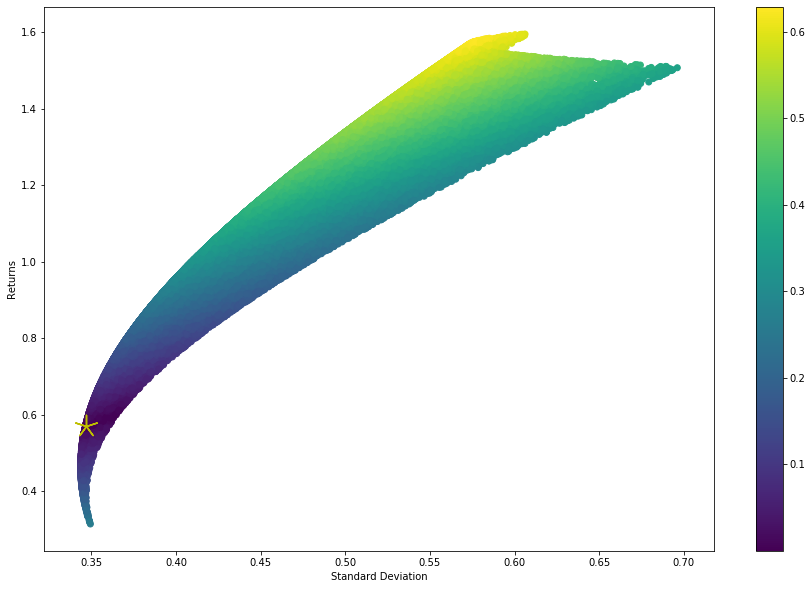

In [87]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.VaR,cmap='viridis')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[1],min_VaR_port[0],marker=(5,2,0),color='y',s=500)
plt.show()

Now you might notice at this point that the results of the minimum VaR portfolio simulations look pretty similar to those of the maximum Sharpe ratio portfolio but that is to be expected considering the calculation method chosen for VaR.

From this we can see that VaR falls when portfolio returns increase and vice versa, whereas the Sharpe ratio increases as portfolio returns increase – so what minimises VaR in terms of returns actually maximises the Sharpe ratio.

Similarly, an increase in portfolio standard deviation increases VaR but decreases the Sharpe ratio – so what maximises VaR in terms of portfolio standard deviation actually minimises the Sharpe ratio.

Saying as we are looking for the minimum VaR and the maximum Sharpe, it makes sense that they will be be achieved with “similar” portfolios.

Now we move onto the second approach to identify the minimum VaR portfolio. Again the code is rather similar to the optimisation code used to calculate the maximum Sharpe and minimum variance portfolios, again with some minor tweaking.

We need a new function that calculates and returns just the VaR of a portfolio, this is defined first. Nothing changes here from our original function that calculated VaR, only that we return a single VaR value rather than the three original values (that previously included portfolio return and standard deviation).

The “min_VaR” function acts much as the “max_sharpe_ratio” and “min_variance” functions did, just with some tweaks to alter the arguments as needed. The constraints are the same, as are the bounds etc.

In [88]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var
def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result
min_port_VaR = min_VaR(mean_returns, cov, alpha, days)

When we run the optimisation, we get the following results:

In [89]:
pd.DataFrame([round(x,4) for x in min_port_VaR['x']],index=tickers).T

,DOCU,SHOP,WMT
0,0.0185,0.2236,0.7578


Once again we see the results are very close to those we were presented with when using the Monte Carlo approach, with the weights being within a couple of percent of each other.

So there you have it, two approaches(Monte Carlo “brute force” and use of Scipy’s “minimize” function) to optimise a portfolio of stocks based on minimising different cost functions ( i.e. the negative Sharpe ratio, the variance and the Value at Risk).